# Estimación del precio de venta en vehículos de ocasión


### 1. Importación de librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from imblearn.over_sampling import SMOTE
import optuna

C:\Users\ESP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Carga de CSV

In [2]:
df = pd.read_csv("true_car_listings/true_car_listings.csv")
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


### 3. Detección de anomalías

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852122 non-null  int64 
 1   Year     852122 non-null  int64 
 2   Mileage  852122 non-null  int64 
 3   City     852122 non-null  object
 4   State    852122 non-null  object
 5   Vin      852122 non-null  object
 6   Make     852122 non-null  object
 7   Model    852122 non-null  object
dtypes: int64(3), object(5)
memory usage: 52.0+ MB


In [4]:
df.describe()

,Price,Year,Mileage
count,852122.000000,852122.000000,8.521220e+05
mean,21464.100210,2013.289145,5.250779e+04
std,13596.202241,3.414987,4.198896e+04
min,1500.000000,1997.000000,5.000000e+00
25%,13000.000000,2012.000000,2.383600e+04
50%,18500.000000,2014.000000,4.025600e+04
75%,26995.000000,2016.000000,7.218600e+04
max,499500.000000,2018.000000,2.856196e+06


In [5]:
df.isnull().sum()

Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [6]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
852117    False
852118    False
852119    False
852120    False
852121    False
Length: 852122, dtype: bool

In [7]:
df.columns

Index(['Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make', 'Model'], dtype='object')

In [8]:
df['Price'].value_counts()

Price
14995    4898
12995    4600
13995    4591
9995     4298
15995    4282
         ... 
49190       1
48457       1
51333       1
48001       1
48681       1
Name: count, Length: 47124, dtype: int64

In [9]:
df['Year'].value_counts()

Year
2014    162432
2015    157516
2016    132136
2017     91608
2013     74701
2012     49764
2011     39768
2010     27539
2008     24713
2007     21171
2009     19061
2006     15079
2005     11005
2004      8117
2003      5649
2002      3800
2001      2584
2000      1933
1999      1254
2018       922
1998       774
1997       596
Name: count, dtype: int64

In [10]:
df['Mileage'].value_counts()

Mileage
10        635
5         350
11        232
12        213
15        183
         ... 
121243      1
169856      1
114893      1
136902      1
57596       1
Name: count, Length: 158836, dtype: int64

In [11]:
df['City'].value_counts()

City
Houston         12703
San Antonio      8078
Louisville       5872
Jacksonville     5675
Austin           5297
                ...  
Los Banos           4
Pen Argyl           4
Armona              4
Port Jervis         4
Royston             2
Name: count, Length: 2553, dtype: int64

In [12]:
df['State'].value_counts()

State
TX    94654
CA    80437
FL    72530
GA    39414
IL    38680
NC    37530
VA    35011
PA    28130
NY    27932
NJ    27852
OH    23259
WA    23149
CO    23004
AZ    22401
TN    19166
MA    17990
MD    17572
IN    16465
MO    16165
KY    13691
AL    13293
WI    11255
MN    10996
CT    10906
UT    10418
OR    10352
MI    10328
SC     9790
OK     9584
LA     8528
KS     7894
AR     6952
NV     6887
MS     6242
NH     5694
NE     4924
IA     4840
NM     4729
ID     3501
HI     2995
DE     2418
MT     1984
ME     1920
RI     1858
AK     1663
WV     1501
SD     1267
VT     1123
ND     1092
Fl      783
WY      610
Va      248
Md      135
Ga      109
ga      100
Az       63
Oh       52
Ca       31
DC       25
Name: count, dtype: int64

In [13]:
df['Vin'].value_counts()

Vin
1FADP3F24DL182433    2
2G1FB1E32F9136442    2
3FA6P0G72DR373223    2
3FADP4EJ5DM144447    2
1G11Y5SLXEU108457    2
                    ..
YV1A22MKXH1010413    1
YV1A22MK2H1013239    1
YV1A22MK0H1015281    1
YV1A22ML5H1004169    1
JH4CU2F69AC027155    1
Name: count, Length: 852075, dtype: int64

In [14]:
df['Make'].value_counts()

Make
Ford             110432
Chevrolet        102268
Toyota            77786
Nissan            66250
Honda             50193
Jeep              40373
Hyundai           35837
Dodge             34368
BMW               32415
GMC               29008
Kia               28636
Mercedes-Benz     26323
Volkswagen        23249
Lexus             20641
Ram               19808
Subaru            16428
Chrysler          16357
Cadillac          15047
Mazda             13365
Audi              12618
Buick             12491
INFINITI          12258
Acura             11049
Lincoln            7120
Volvo              5106
MINI               4375
Porsche            4106
Land               4096
Mitsubishi         4080
Scion              3043
Jaguar             2200
Pontiac            1783
FIAT               1782
Mercury            1076
Maserati           1047
Saturn              963
HUMMER              949
smart               713
Bentley             367
Ferrari             345
Suzuki              334
Saab       

In [15]:
df['Model'].value_counts()

Model
Silverado         24932
Grand             17321
Accord            14502
F-1504WD          14177
Altima2.5         11288
                  ...  
300Anniversary        1
XC90Premier           1
Skylark4dr            1
Mazda3iSport          1
624dr                 1
Name: count, Length: 2736, dtype: int64

### 4. Visualización de datos

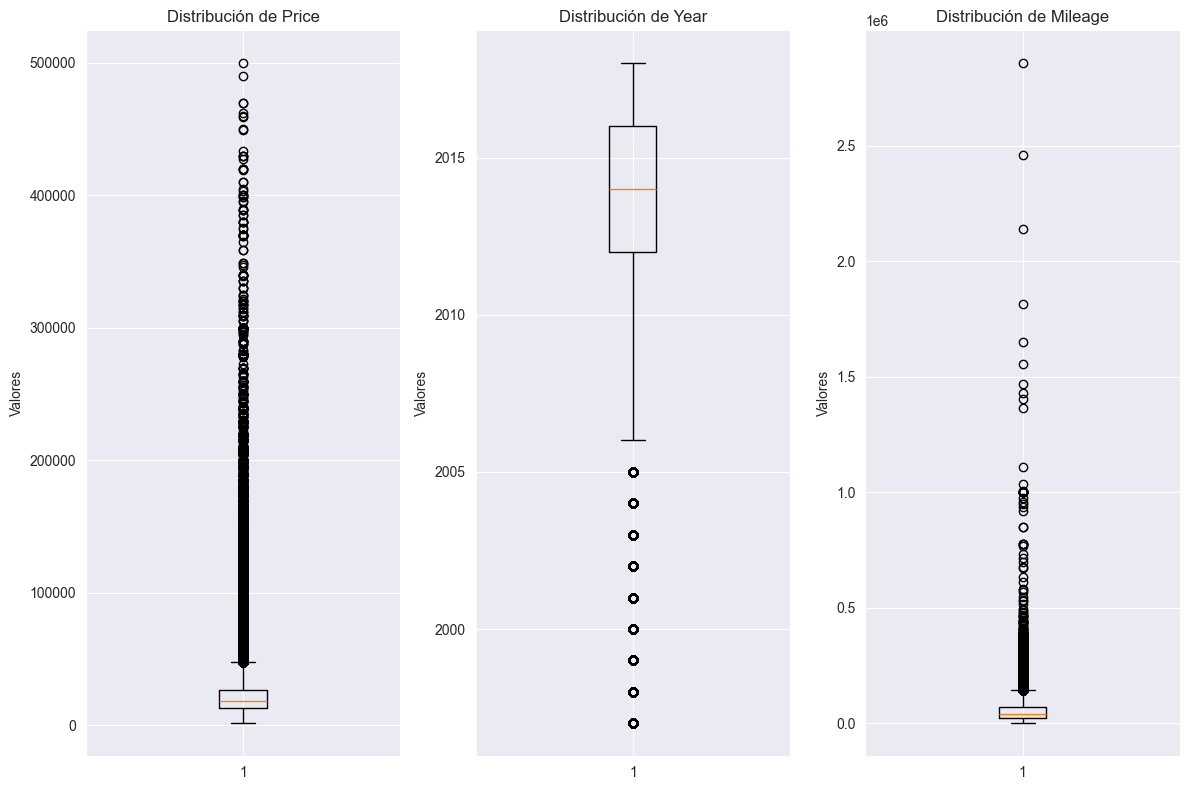

In [16]:
categorias = ['Price', 'Year', 'Mileage']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].boxplot(df[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()

### 5. Ingeniería de características


In [17]:
df.shape

(852122, 8)

In [18]:
categoricas = ['City', 'State', 'Vin', 'Make', 'Model']

df[categoricas] = df[categoricas].apply(lambda col: LabelEncoder().fit_transform(col))

In [19]:
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,646,49,3972,1,1194
1,10888,2013,19606,1260,39,3707,1,1193
2,8995,2013,48851,646,49,3970,1,1194
3,10999,2014,39922,2490,6,3824,1,1193
4,14799,2016,22142,1231,50,42,1,1196


In [20]:
df.shape

(852122, 8)

### 6. Entrenamiento del modelo


In [21]:
X = df.drop('Price',axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Creamos el modelo de red neuronal
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Entrada con la cantidad de características
    Dense(8, activation='relu'),  # 2a capa oculta
    Dense(1, activation='linear')  # Capa de salida (sin activación para regresión)
])
# Compilar el modelo con una función de pérdida para regresión
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# Mostramos configuración
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73 (292.00 B)

 Trainable params: 73 (292.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 644271104.0000 - mae: 12646.4053 - val_loss: 144959552.0000 - val_mae: 7704.8354
Epoch 2/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 137504992.0000 - mae: 7621.6758 - val_loss: 143836432.0000 - val_mae: 7475.2236
Epoch 3/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 139140592.0000 - mae: 7534.0972 - val_loss: 141402016.0000 - val_mae: 7452.9692
Epoch 4/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 133172656.0000 - mae: 7452.0396 - val_loss: 145699376.0000 - val_mae: 7214.7988
Epoch 5/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 131840680.0000 - mae: 7432.0547 - val_loss: 143517744.0000 - val_mae: 7822.9155
Epoch 6/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 128528024.0000 - mae: 7405.3218 - val_loss: 140290896.0000 - val_mae: 7413.3516
Epoch 7/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 133595208.0000 - mae: 7418.2505 - val_loss: 143164736.0000 - val

5326/5326 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 135527056.0000 - mae: 7279.7671
Pérdida: 130749896.0, Precisión: 7273.6611328125


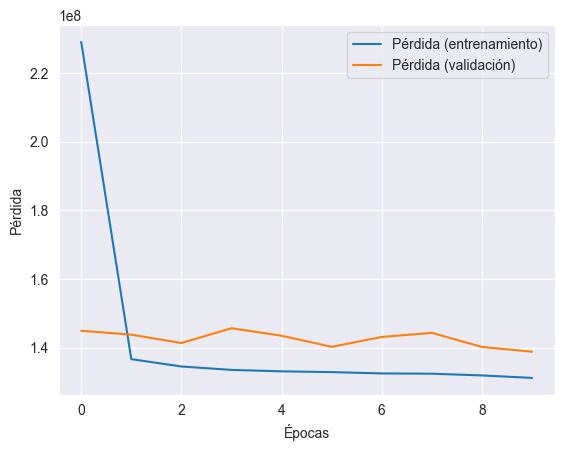

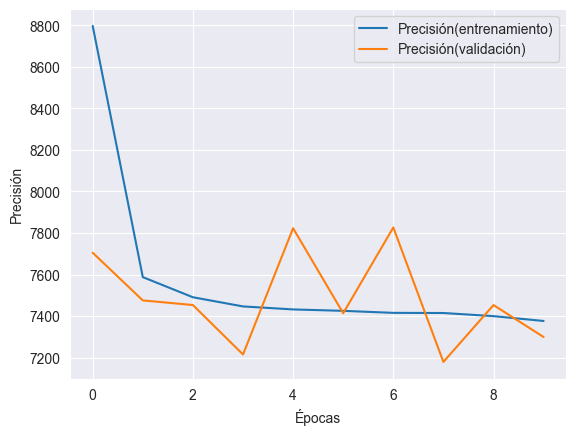

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['mae'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_mae'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [25]:
def build_model(hp):
 model = Sequential([
     Dense(units=hp.Int('units', min_value=32, max_value=512,step=32), activation='relu'),
     Dense(1, activation='linear')
 ])
 model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice('learning_rate', [0.001, 0.01])),loss = 'mean_squared_error', metrics = ['mae'])
 return model

tuner = RandomSearch(
 build_model,
 objective='val_loss',
 max_trials=5,
 directory='./my_dir',
 project_name='prediccion'
)
tuner.search(X_train, y_train, validation_split=0.2)

Reloading Tuner from ./my_dir\prediccion\tuner0.json


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [27]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
# Ahora usa X_train_split, y_train_split en el entrenamiento
history = best_model.fit(X_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 168283984.0000 - mae: 8432.2842 - val_loss: 132206224.0000 - val_mae: 7552.5088
Epoch 2/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 136670944.0000 - mae: 7493.2202 - val_loss: 130097672.0000 - val_mae: 7263.6045
Epoch 3/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 130384400.0000 - mae: 7283.4995 - val_loss: 129105392.0000 - val_mae: 7148.3892
Epoch 4/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 131094992.0000 - mae: 7223.3403 - val_loss: 127165344.0000 - val_mae: 7265.2427
Epoch 5/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 130897904.0000 - mae: 7147.9902 - val_loss: 127798960.0000 - val_mae: 6918.3975
Epoch 6/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 130763704.0000 - mae: 7096.3364 - val_loss: 124652248.0000 - val_mae: 6823.6914
Epoch 7/10
17043/17043 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 125274584.0000 - mae: 7019.7798 - val_loss: 127629504.0000 - val_

5326/5326 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 130942784.0000 - mae: 6930.9941
Pérdida: 126294992.0, Precisión: 6917.7509765625


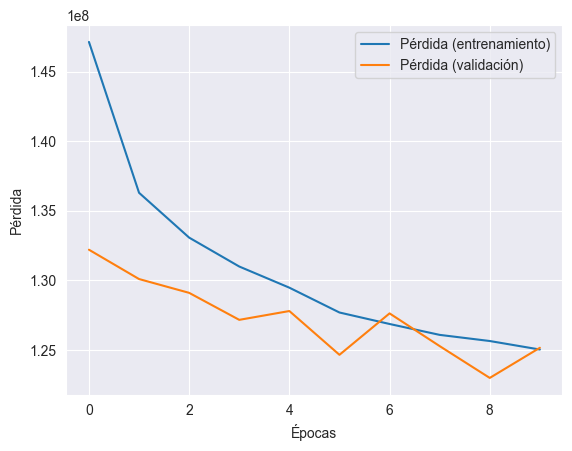

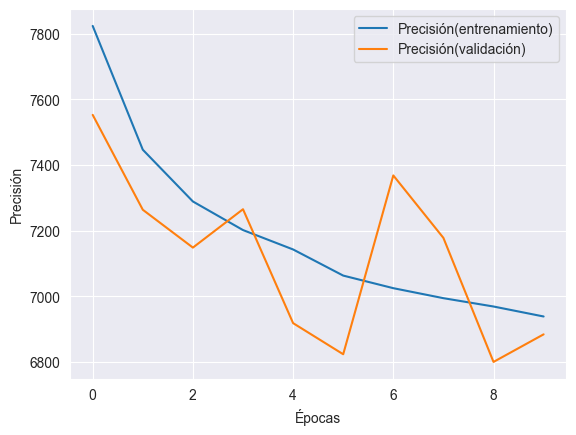

In [29]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['mae'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_mae'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [30]:
# Definir la función objetivo que Optuna optimizará
def objective(trial):
 # Espacios de búsqueda de hiperparámetros (esto son ejemplos)
 units = trial.suggest_int('units', 32, 512, step=32)
 lr = trial.suggest_categorical('learning_rate', [0.001, 0.01,0.1])

 # Crear el modelo
 model = Sequential([
    Input(shape=(X_train_split.shape[1],)), # Definir forma de la entrada
    Dense(units=units, activation='relu'),
    Dense(1, activation='linear')
 ])

 model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss='mean_squared_error',metrics=['mae'])

 model.fit(X_train_split, y_train_split, epochs=10, validation_split=0.2, verbose=1)

 # Obtener la pérdida en la validación para optimizar
 val_loss = model.history.history['val_loss'][-1]
 return val_loss
# Crear estudio de Optuna y ejecutar la optimización
# Queremos minimizar la pérdida (val_loss)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5) # 5 intentos de prueba, puedes aumentar este número
# Mostrar los mejores hiperparámetros encontrados
print(f'Best hyperparameters: {study.best_params}')

[I 2025-02-05 20:12:00,967] A new study created in memory with name: no-name-b10fc125-0673-459d-93a0-26b9d620d9d9


Epoch 1/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 171193504.0000 - mae: 8464.1533 - val_loss: 145733968.0000 - val_mae: 7392.5767
Epoch 2/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 139152992.0000 - mae: 7579.7471 - val_loss: 150329008.0000 - val_mae: 8268.0498
Epoch 3/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 134603392.0000 - mae: 7482.8457 - val_loss: 138350560.0000 - val_mae: 7252.8398
Epoch 4/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 135082912.0000 - mae: 7463.0088 - val_loss: 139529072.0000 - val_mae: 7691.4106
Epoch 5/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 138389520.0000 - mae: 7440.6382 - val_loss: 138053872.0000 - val_mae: 7094.7529
Epoch 6/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 131093464.0000 - mae: 7394.0923 - val_loss: 138146688.0000 - val_mae: 7125.9521
Epoch 7/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 132532520.0000 - mae: 7346.7388 - val_loss: 137274208.0000 - val_

[I 2025-02-05 20:15:50,994] Trial 0 finished with value: 140892416.0 and parameters: {'units': 256, 'learning_rate': 0.01}. Best is trial 0 with value: 140892416.0.


Epoch 1/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 163525632.0000 - mae: 8388.6621 - val_loss: 137541104.0000 - val_mae: 7360.3657
Epoch 2/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - loss: 134556384.0000 - mae: 7519.3770 - val_loss: 145290752.0000 - val_mae: 8143.4736
Epoch 3/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 136265296.0000 - mae: 7390.5605 - val_loss: 140691104.0000 - val_mae: 7877.7114
Epoch 4/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 135302336.0000 - mae: 7278.9683 - val_loss: 136013456.0000 - val_mae: 7074.2085
Epoch 5/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 129955624.0000 - mae: 7190.2695 - val_loss: 135286512.0000 - val_mae: 7139.5752
Epoch 6/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 128572160.0000 - mae: 7147.2505 - val_loss: 131429152.0000 - val_mae: 7075.4985
Epoch 7/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 126704664.0000 - mae: 7094.5078 - val_loss: 134189128.0000 - val_

[I 2025-02-05 20:20:27,228] Trial 1 finished with value: 128396768.0 and parameters: {'units': 96, 'learning_rate': 0.001}. Best is trial 1 with value: 128396768.0.


Epoch 1/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 170407856.0000 - mae: 8553.6670 - val_loss: 147562400.0000 - val_mae: 7897.5562
Epoch 2/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 140816784.0000 - mae: 7551.8691 - val_loss: 139230960.0000 - val_mae: 7118.6411
Epoch 3/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 132527568.0000 - mae: 7394.6475 - val_loss: 148156336.0000 - val_mae: 8166.4604
Epoch 4/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 127890504.0000 - mae: 7186.0908 - val_loss: 132732672.0000 - val_mae: 7112.2183
Epoch 5/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 128675280.0000 - mae: 7163.5713 - val_loss: 131534696.0000 - val_mae: 7195.4888
Epoch 6/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 128642840.0000 - mae: 7104.0352 - val_loss: 130838944.0000 - val_mae: 7201.7446
Epoch 7/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 125425472.0000 - mae: 7072.3110 - val_loss: 130675584.0000 - val_

[I 2025-02-05 20:25:17,782] Trial 2 finished with value: 128454696.0 and parameters: {'units': 96, 'learning_rate': 0.001}. Best is trial 1 with value: 128396768.0.


Epoch 1/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 1637835648.0000 - mae: 11904.5283 - val_loss: 154848272.0000 - val_mae: 7649.9292
Epoch 2/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 162874384.0000 - mae: 8453.1641 - val_loss: 190474624.0000 - val_mae: 8161.9180
Epoch 3/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 165834000.0000 - mae: 8426.9707 - val_loss: 152636272.0000 - val_mae: 7923.3823
Epoch 4/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 165233408.0000 - mae: 8376.7881 - val_loss: 153610208.0000 - val_mae: 8079.2231
Epoch 5/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 158526608.0000 - mae: 8331.8965 - val_loss: 152838784.0000 - val_mae: 7816.2646
Epoch 6/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 163300912.0000 - mae: 8363.8984 - val_loss: 211811216.0000 - val_mae: 8793.9717
Epoch 7/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 163187920.0000 - mae: 8365.8975 - val_loss: 152231680.0000 - va

[I 2025-02-05 20:30:45,557] Trial 3 finished with value: 153334592.0 and parameters: {'units': 352, 'learning_rate': 0.1}. Best is trial 1 with value: 128396768.0.


Epoch 1/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 863134784.0000 - mae: 9960.5947 - val_loss: 157588752.0000 - val_mae: 8294.9482
Epoch 2/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 160658064.0000 - mae: 8371.2070 - val_loss: 171518912.0000 - val_mae: 7869.4790
Epoch 3/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 166371424.0000 - mae: 8406.3994 - val_loss: 171617232.0000 - val_mae: 8044.1338
Epoch 4/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 160532800.0000 - mae: 8344.7549 - val_loss: 155944960.0000 - val_mae: 7579.4287
Epoch 5/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 161909008.0000 - mae: 8306.4609 - val_loss: 169669168.0000 - val_mae: 9207.7949
Epoch 6/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 163839888.0000 - mae: 8354.6377 - val_loss: 181130352.0000 - val_mae: 9737.7402
Epoch 7/10
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 165986896.0000 - mae: 8403.7832 - val_loss: 179003856.0000 - val_

[I 2025-02-05 20:36:09,074] Trial 4 finished with value: 161963072.0 and parameters: {'units': 288, 'learning_rate': 0.1}. Best is trial 1 with value: 128396768.0.


Best hyperparameters: {'units': 96, 'learning_rate': 0.001}


In [ ]:
best_params = study.best_params  # Obtener los mejores hiperparámetros encontrados

# Crear y entrenar el mejor modelo
best_model = Sequential([
    Input(shape=(X_train_split.shape[1],)), # Definir forma de la entrada
    Dense(units=best_params['units'], activation='relu'),
    Dense(1, activation='linear')  # Asegúrate de que la activación final sea adecuada
])

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='mean_squared_error',
    metrics=['mae']
)

best_model.fit(X_train_split, y_train_split, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/50
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - loss: 203031856.0000 - mae: 8876.9248 - val_loss: 138461408.0000 - val_mae: 7236.1997
Epoch 2/50
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 131138816.0000 - mae: 7475.9429 - val_loss: 136825056.0000 - val_mae: 7384.2090
Epoch 3/50
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 131723064.0000 - mae: 7360.1284 - val_loss: 137059808.0000 - val_mae: 7583.0845
Epoch 4/50
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 133429424.0000 - mae: 7274.9775 - val_loss: 135703344.0000 - val_mae: 7493.9937
Epoch 5/50
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 128725984.0000 - mae: 7123.7729 - val_loss: 132282584.0000 - val_mae: 6913.5996
Epoch 6/50
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 126034504.0000 - mae: 7071.1016 - val_loss: 130834072.0000 - val_mae: 7109.2324
Epoch 7/50
13634/13634 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 124825488.0000 - mae: 7026.3589 - val_loss: 130286344.0000 - val_

In [ ]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['mae'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_mae'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()